In [1]:
%matplotlib inline
import gym
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import deque
from IPython import display
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from scipy import stats
from training_methods import *
%load_ext autoreload
%autoreload

run_name = 0

In [2]:
env = gym.make('CartPole-v1')
env_state_observer = EnvStateObserver(lambda x: x, concat_states_count=3)

# env = gym.make('Pong-v0')
# env_state_observer = EnvStateObserver(preprocess_input_pong_v0, concat_states_count=4)

# env = gym.envs.make("Breakout-v0")
# env_state_observer = EnvStateObserver(preprocess_input_breakout_v0, concat_states_count=4)

# env.render(close=True)
# plt.imshow(env.render('rgb_array'))
sample_state = env_state_observer.env_reset(env)
print('Actions: {}'.format(env.action_space.n))
print('Raw observation space: {}'.format(env.observation_space.shape))
print('Max episode steps: {}'.format(env.spec.max_episode_steps))
print('Preprocessed observation space: {}'.format(sample_state.shape))
print('Parameters: {}'.format(np.prod(sample_state.shape)))

[2017-09-03 13:21:36,605] Making new env: CartPole-v1


Actions: 2
Raw observation space: (4,)
Max episode steps: 500
Preprocessed observation space: (12,)
Parameters: 12


## Basic Actor-Critic

In [3]:
class ActorCriticAgent:
    def __init__(self, params):
        self.params = params
        self.memory_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_next_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_actions = np.zeros((2 * self.params.max_memory_size))
        self.memory_rewards = np.zeros((2 * self.params.max_memory_size, 1))
        self.cnt = 0
        self._build_actor_model()
        self._build_critic_model()
        
#     def _build_shared_network(x, add_summaries=False):
#         conv1 = tf.contrib.layers.conv2d(x, 16, 8, 4, activation_fn=tf.nn.relu, scope="conv1")
#         conv2 = tf.contrib.layers.conv2d(conv1, 32, 4, 2, activation_fn=tf.nn.relu, scope="conv2")

#         fc1 = tf.contrib.layers.fully_connected(
#             inputs=tf.contrib.layers.flatten(conv2),
#             num_outputs=256,
#             scope="fc1")

#         if add_summaries:
#             tf.contrib.layers.summarize_activation(conv1)
#             tf.contrib.layers.summarize_activation(conv2)
#             tf.contrib.layers.summarize_activation(fc1)
#         return fc1

    def _build_actor_model(self):
        with tf.variable_scope('actor'):
            self.actor_x = tf.placeholder("float", [None, self.params.state_size], name="State")
            self.actor_y = tf.placeholder("float", [None, 1], name="Target")
            self.actor_action = tf.placeholder(tf.int32, [None,], name="Action")

            # Pong:
#             x = tf.reshape(self.actor_x, (tf.shape(self.actor_x)[0], 19, 16, 4))
#             conv1 = tf.contrib.layers.conv2d(x, 16, 4, 2, activation_fn=tf.nn.relu)
#             flattened = tf.contrib.layers.flatten(conv1)

            # Breakout:
#             x = tf.reshape(self.actor_x, (tf.shape(self.actor_x)[0], 80, 70, 4))
#             conv1 = tf.contrib.layers.conv2d(x, 16, 8, 4, activation_fn=tf.nn.relu)
#             conv2 = tf.contrib.layers.conv2d(conv1, 32, 4, 2, activation_fn=tf.nn.relu)
#             flattened = tf.contrib.layers.flatten(conv2)

            # Cartpole:
            flattened = self.actor_x
            
            fc1 = tf.contrib.layers.fully_connected(flattened, 128,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.contrib.layers.xavier_initializer())
            
            fc2 = tf.contrib.layers.fully_connected(fc1, self.params.action_size,
                activation_fn=None,
                weights_initializer=tf.contrib.layers.xavier_initializer())
            
            self.actor_action_probs = tf.nn.softmax(fc2)

            actions_ohe = tf.one_hot(self.actor_action, depth=self.params.action_size)
            self.picked_action_probs = tf.reduce_sum(self.actor_action_probs * actions_ohe, axis=1, keep_dims=True)

            self.actor_cost = tf.reduce_mean(-tf.log(1e-6 + self.picked_action_probs) * self.actor_y)
            self.actor_train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
                .minimize(self.actor_cost)

    def _build_critic_model(self):
        with tf.variable_scope('critic'):
            self.critic_x = tf.placeholder("float", [None, self.params.state_size], name="State")
            self.critic_y = tf.placeholder("float", [None, 1], name="Target")

            # Pong:
#             x = tf.reshape(self.critic_x, (tf.shape(self.critic_x)[0], 19, 16, 4))
#             conv1 = tf.contrib.layers.conv2d(x, 16, 4, 2, activation_fn=tf.nn.relu)
#             flattened = tf.contrib.layers.flatten(conv1)

            # Breakout:
#             x = tf.reshape(self.critic_x, (tf.shape(self.critic_x)[0], 80, 70, 4))
#             conv1 = tf.contrib.layers.conv2d(x, 16, 8, 4, activation_fn=tf.nn.relu)
#             conv2 = tf.contrib.layers.conv2d(conv1, 32, 4, 2, activation_fn=tf.nn.relu)
#             flattened = tf.contrib.layers.flatten(conv2)

            # Cartpole:
            flattened = self.critic_x
            
            fc1 = tf.contrib.layers.fully_connected(flattened, 128,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.contrib.layers.xavier_initializer())
            
            self.critic_value = tf.contrib.layers.fully_connected(fc1, 1,
                activation_fn=None,
                weights_initializer=tf.contrib.layers.xavier_initializer())
            
            self.critic_cost = tf.reduce_mean(tf.squared_difference(self.critic_value, self.critic_y))
            self.critic_train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
                .minimize(self.critic_cost)
            
    def remember(self, state, action, reward, next_state, frame):
        self.memory_states[self.cnt] = state
        self.memory_next_states[self.cnt] = next_state
        self.memory_actions[self.cnt] = action
        self.memory_rewards[self.cnt] = reward
        self.cnt += 1
        
        if self.cnt == 2 * self.params.max_memory_size:
            n = self.params.max_memory_size
            self.memory_states[:n] = self.memory_states[-n:]
            self.memory_next_states[:n] = self.memory_next_states[-n:]
            self.memory_actions[:n] = self.memory_actions[-n:]
            self.memory_rewards[:n] = self.memory_rewards[-n:]
            self.cnt = n

    def act(self, session, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(session, state, frame)
    
    def act_greedy(self, session, state, frame):
        act_probs = session.run(self.actor_action_probs, {self.actor_x: [state]})[0]
        return np.random.choice(np.arange(len(act_probs)), p=act_probs)

    def think(self, session, batch_size, episode):
        cnt = self.cnt
        
        values = session.run(self.critic_value, {self.critic_x: self.memory_states[:cnt]})
        nextValues = session.run(self.critic_value, {self.critic_x: self.memory_next_states[:cnt]})
        
        criticY = self.memory_rewards[:cnt] + self.params.gamma * nextValues[:cnt]
        actorY = criticY - values

        P = np.random.permutation(cnt)
        for i in range(0, cnt, batch_size):
            batch_indexes = P[i: i + batch_size]
            states = self.memory_states[batch_indexes]
            actorys = actorY[batch_indexes]
            criticys = criticY[batch_indexes]
            actions = self.memory_actions[batch_indexes]
            
            _ = session.run(self.actor_train_op,
                            {self.actor_x: states, self.actor_y: actorys, self.actor_action: actions})
            _ = session.run(self.critic_train_op,
                            {self.critic_x: states, self.critic_y: criticys})

State shape (12,), actions 2
Run: 1
episode: 5/100, reward 24.8, frames 9, exploration rate: 0.91
episode: 10/100, reward 31.5, frames 63, exploration rate: 0.79
episode: 15/100, reward 33.7, frames 39, exploration rate: 0.68
episode: 20/100, reward 35.0, frames 8, exploration rate: 0.58
episode: 25/100, reward 59.6, frames 160, exploration rate: 0.5
episode: 30/100, reward 87.3, frames 230, exploration rate: 0.43
episode: 35/100, reward 147.5, frames 181, exploration rate: 0.37
episode: 40/100, reward 250.7, frames 167, exploration rate: 0.32
episode: 45/100, reward 311.0, frames 346, exploration rate: 0.28
episode: 50/100, reward 377.3, frames 499, exploration rate: 0.24
episode: 55/100, reward 345.0, frames 144, exploration rate: 0.2
episode: 60/100, reward 248.6, frames 188, exploration rate: 0.18
episode: 65/100, reward 193.1, frames 134, exploration rate: 0.15
episode: 70/100, reward 100.9, frames 69, exploration rate: 0.13
episode: 75/100, reward 90.4, frames 187, exploration ra

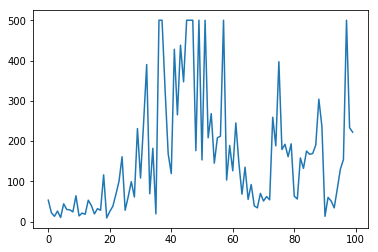

In [4]:
tf.reset_default_graph()

params = LearningParameters(env, env_state_observer.env_reset(env), episodes_count=100)
params.max_frame_in_episode = min(params.max_frame_in_episode, 1000)
params.epsilon_min = 0.05
params.max_memory_size = 2000
params.pong_reset_discounted_reward = False
agent = ActorCriticAgent(params)

run_name += 1
print('Run: ' + str(run_name))

saver = TfSaver('logs/ac')

# Train on GPU
# config = tf.ConfigProto(log_device_placement=True)
# config.gpu_options.per_process_gpu_memory_fraction=0.7
# config.operation_timeout_in_ms=60000

# Train on CPU
config = tf.ConfigProto(device_count = {'GPU': 0})

with tf.Session(config=config) as session:
    session.run(tf.global_variables_initializer())

    saver.load_latest_checkpoint(session)
    
#     tf_writer = tf.summary.FileWriter('logs/run' + str(run_name), session.graph)

    agent, rewards = train_discounted_rewards(session, saver, env, agent, env_state_observer, params,
                                              normalize_rewards=True)
    # agent, rewards = train_reward_is_time(env, agent, params)
    # agent, rewards = train(env, agent, params)
    plt.plot(rewards)

In [9]:
with tf.Session(config=config) as session:
    session.run(tf.global_variables_initializer())
    evaluate(session, env, agent, env_state_observer, params, 500)

Total reward: -9.0


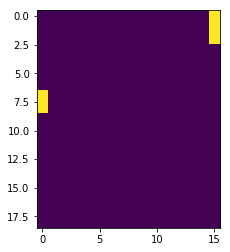

In [10]:
with tf.Session(config=config) as session:
    session.run(tf.global_variables_initializer())
    show(session, env, agent, env_state_observer, params, 200, width=19, height=16, greedy=True)

In [18]:
# Save rewards/model
# pd.DataFrame(rewards).to_csv('models/rewards_40K_50K.csv', header=None)
saver = tf.train.Saver()
saver.save(session, 'models/Pong ActorCriticAgent', global_step=9000)

'models/Pong ActorCriticAgent-9000'